# Init

In [3]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
from modules.data_generation import DataGenerator
from modules import filtering, data_projection as dp
import matplotlib.pyplot as plt

logger = logging.getLogger("beta2")


## Load data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [5]:
feature_type = "closest_heavy_inv" # "contacts_5_cutoff", "closest_heavy_inv" or "CA_inv"
working_dir = os.path.expanduser("~/projects/gpcr/mega/Result_Data/beta2-dror/clustering/{}/".format(feature_type))
raw_data = np.load(working_dir + "samples.npy")
scale_data = True
cluster_indices = np.loadtxt(working_dir + 'cluster_indices_.txt')
data = utils.vectorize(raw_data)  # Our training data to classifiers
labels = utils.create_class_labels(cluster_indices)  #Our training labels to classifiers
feature_to_resids = np.load(
    working_dir + "feature_to_resids.npy")  #Mapping from residue Id to the index of that residue in the data (for proteins with missing residues)
if len(data) != len(labels) or data.shape[1] != len(feature_to_resids):
    raise Exception()
logger.info("Loaded data of shape %s and %s clusters for feature_type %s", data.shape, len(set(cluster_indices)), feature_type)


2018-12-05 18:38:35 beta2-INFO: Loaded data of shape (857, 39903) and 3 clusters for feature_type closest_heavy_inv


## Filter features customly

In [ ]:
filter_indices = np.random.randint(0, data.shape[1], size=1000)
#filter_indices = [i for i in range(0, data.shape[1], 150)]
data = data[:,filter_indices]
feature_to_resids = feature_to_resids[filter_indices]

## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [6]:
n_iterations, n_splits = 1, 1
rbm_data = np.copy(data)
np.random.shuffle(rbm_data)
filter_by_distance_cutoff, use_inverse_distances = True, True

feature_extractors = [
     fe.MlpFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
                             hidden_layer_sizes=(100,), #, 50, 25),
                             activation="logistic",
                             randomize=True,
                             filter_by_distance_cutoff=filter_by_distance_cutoff),
     #fe.RbmFeatureExtractor(rbm_data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
     #                      n_components=8,
     #                       use_inverse_distances=use_inverse_distances,
     #                      filter_by_distance_cutoff=filter_by_distance_cutoff),                           
     fe.ElmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
                            filter_by_distance_cutoff=filter_by_distance_cutoff,
                            n_nodes=3000,
                            use_inverse_distances=use_inverse_distances,
                            alpha=1, activation="logistic"),
     #fe.KLFeatureExtractor(data, cluster_indices, n_splits=n_splits,
     #                        filter_by_distance_cutoff=filter_by_distance_cutoff),
     #fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits,
     #                       filter_by_distance_cutoff=filter_by_distance_cutoff),
     fe.RandomForestFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
                             filter_by_distance_cutoff=filter_by_distance_cutoff),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2018-12-05 18:38:37 beta2-INFO: Done. using 3 feature extractors


# Run the relevance analysis

In [7]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2018-12-05 18:38:38 beta2-INFO: Computing relevance for extractors MLP
2018-12-05 18:38:38 Extracting features-INFO: Performing feature extraction with MLP on data of shape (857, 39903)
2018-12-05 18:38:39 filtering-INFO: Number of features before distance cutoff based filtering is 39903
2018-12-05 18:38:39 filtering-INFO: Number of features after distance cutoff based filtering is 2245
2018-12-05 18:38:39 Extracting features-INFO: Using all data in training and validation sets
2018-12-05 18:38:40 Extracting features-INFO: Done with MLP
2018-12-05 18:38:40 Extracting features-INFO: ------------------------------
2018-12-05 18:38:40 beta2-INFO: Computing relevance for extractors ELM
2018-12-05 18:38:40 Extracting features-INFO: Performing feature extraction with ELM on data of shape (857, 39903)
2018-12-05 18:38:40 filtering-INFO: Number of features before distance cutoff based filtering is 39903
2018-12-05 18:38:41 filtering-INFO: Number of features after distance cutoff based filterin

# Remap and persist results 

In [8]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir, 
                                     pdb_file=working_dir + "analysis/all_orig.pdb",
                                     feature_to_resids=feature_to_resids, filter_results=True)
    p.average()
    p.evaluate_performance()
    p.persist()
    postprocessors.append([p])
logger.info("Done")


2018-12-05 18:38:45 utils-INFO: Rescaling feature importances ...
2018-12-05 18:38:45 filtering-INFO: Filtering feature importances by median ...
2018-12-05 18:38:45 utils-INFO: Rescaling feature importances ...
2018-12-05 18:38:45 utils-INFO: Rescaling feature importances ...
2018-12-05 18:38:45 projection-INFO: Scoring raw projections.
2018-12-05 18:38:46 postprocessing-WARNING: importance is None for residues set([1, 130, 228, 6, 8, 265, 2, 13, 17, 18, 21, 22, 9, 345, 15])
2018-12-05 18:38:46 postprocessing-WARNING: importance is None for residues set([1, 130, 228, 6, 8, 265, 2, 13, 17, 18, 21, 22, 9, 345, 15])
2018-12-05 18:38:47 postprocessing-WARNING: importance is None for residues set([1, 130, 228, 6, 8, 265, 2, 13, 17, 18, 21, 22, 9, 345, 15])
2018-12-05 18:38:47 postprocessing-WARNING: importance is None for residues set([1, 130, 228, 6, 8, 265, 2, 13, 17, 18, 21, 22, 9, 345, 15])
2018-12-05 18:38:47 utils-INFO: Rescaling feature importances ...
2018-12-05 18:38:47 filtering-

# Visualize results

2018-12-05 18:38:51 utils-INFO: Rescaling feature importances ...


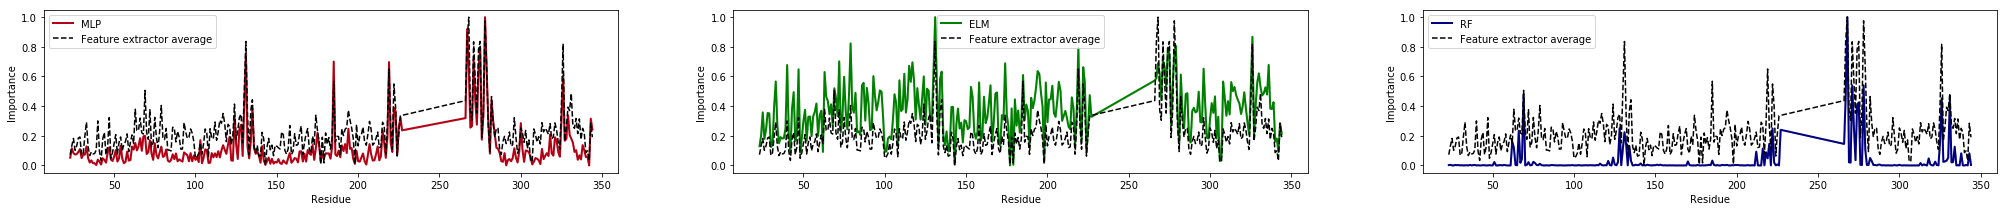

2018-12-05 18:38:51 beta2-INFO: Done. The settings were n_iterations, n_splits = 1, 1.
Filtering (filter_by_distance_cutoff = True)


In [9]:
visualization.visualize(postprocessors,
          show_importance=True, 
          show_performance=False, 
          show_projected_data=False)

logger.info("Done. The settings were n_iterations, n_splits = %s, %s.\nFiltering (filter_by_distance_cutoff = %s)", 
            n_iterations, n_splits, filter_by_distance_cutoff)